In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from IPython.display import clear_output, display

## Modeling

In [36]:
df = pd.read_csv('../data/features_for_model.csv', index_col=0)
df.shape

/var/folders/kj/yvh7dv5569ggqx7tcy8crpp00000gn/T/ipykernel_84099/1394540614.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/features_for_model.csv', index_col=0)


(1023552, 16)

In [37]:
df['stmt_date'] = pd.to_datetime(df['stmt_date'])

In [38]:
df['stmt_date'].dt.year.value_counts().sort_index()

stmt_date
2007    144528
2008    161863
2009    171150
2010    175399
2011    184973
2012    185639
Name: count, dtype: int64

In [39]:
df['available_date'] = (df['stmt_date'] + pd.Timedelta(days=180)) + pd.offsets.MonthEnd(0)

In [40]:
df['def_date'] = pd.to_datetime(df['def_date'])

# Calculate 1 year after stmt_date
one_year_after = df['available_date'] + pd.DateOffset(years=1)

# Define default if def_date is between stmt_date and one_year_after
df['default_2'] = ((df['def_date'] >= df['available_date']) & (df['def_date'] <= one_year_after)).astype(int)

In [41]:
df['default'].mean(),df['default_2'].mean()

(np.float64(0.0112783717876571), np.float64(0.012942185643719127))

In [42]:
modeling_df = df.drop(['def_date','quick_ratio_v1'],axis=1)
modeling_df.isna().sum()

id                       0
stmt_date                0
HQ_city                277
legal_struct             0
ateco_sector             0
fs_year                  0
asst_tot                 0
COGS                    24
financial_leverage     156
profitability_ratio     20
quick_ratio_v2          47
cash_assets_ratio       17
dscr                   405
default                  0
available_date           0
default_2                0
dtype: int64

In [43]:
modeling_df['HQ_city'] = modeling_df['HQ_city'].fillna(-1.0)

In [44]:
modeling_df['quick_ratio_v2'] = modeling_df['quick_ratio_v2'].replace([-np.inf,np.inf],0)

In [45]:
modeling_df[~modeling_df.index.isin(modeling_df.dropna().index)]['default'].value_counts()

default
0    550
1      9
Name: count, dtype: int64

In [46]:
modeling_df[modeling_df.index.isin(modeling_df.dropna().index)]['default'].value_counts()

default
0    1011458
1      11535
Name: count, dtype: int64

In [47]:
modeling_df[modeling_df.index.isin(modeling_df.dropna().index)]['default_2'].value_counts()

default_2
0    1009759
1      13234
Name: count, dtype: int64

In [48]:
### we'll try dropping NA's for now
modeling_df = modeling_df.dropna().copy()

In [49]:
modeling_df.sort_values('stmt_date', inplace=True)

In [50]:
train_df = modeling_df.iloc[:int(len(modeling_df)*0.8)]

In [51]:
test_df = modeling_df[~modeling_df.index.isin(train_df.index)]

In [52]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [53]:
modeling_df.columns.to_list()

['id',
 'stmt_date',
 'HQ_city',
 'legal_struct',
 'ateco_sector',
 'fs_year',
 'asst_tot',
 'COGS',
 'financial_leverage',
 'profitability_ratio',
 'quick_ratio_v2',
 'cash_assets_ratio',
 'dscr',
 'default',
 'available_date',
 'default_2']

In [54]:
feature_list = [
                'HQ_city',
                 # 'legal_struct',
                 'ateco_sector',
                 'asst_tot',
                 'COGS',
                 'financial_leverage',
                 'profitability_ratio',
                 'quick_ratio_v2',
                 'cash_assets_ratio',
                 'dscr',]

In [60]:
feature_list = [
                # 'HQ_city',
                 # 'legal_struct',
                 'ateco_sector',
                 'asst_tot',
                 'COGS',
                 'financial_leverage',
                 'profitability_ratio',
                 # 'quick_ratio_v2',
                 'cash_assets_ratio',
                 # 'dscr',
]

In [61]:
formula = 'default_2 ~ '+' + '.join(feature_list)
formula

'default_2 ~ ateco_sector + asst_tot + COGS + financial_leverage + profitability_ratio + cash_assets_ratio'

In [62]:
model = smf.logit(formula, data = train_df) 
logit_model_sm = model.fit()
print(logit_model_sm.summary())

Optimization terminated successfully.
         Current function value: 0.071350
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:              default_2   No. Observations:               818394
Model:                          Logit   Df Residuals:                   818387
Method:                           MLE   Df Model:                            6
Date:                Wed, 30 Oct 2024   Pseudo R-squ.:                 0.05817
Time:                        01:43:39   Log-Likelihood:                -58393.
converged:                       True   LL-Null:                       -61999.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -4.6323      0.032   -142.684      0.000      -4.696      -4.569
a

In [63]:
predictions = test_df[['default']].copy()
predictions['predicted_probability'] = logit_model_sm.predict(test_df)
# predictions.dropna(inplace=True)
predictions.head()

,default,predicted_probability
Unnamed: 0,,
2471028,0,0.023471
2498807,0,0.007457
2471048,0,0.002610
2471109,0,0.014760
2498783,0,0.009151


In [64]:
predictions.isna().mean()

default                  0.0
predicted_probability    0.0
dtype: float64

In [65]:
from sklearn import metrics

In [66]:
metrics.roc_auc_score(y_score=predictions['predicted_probability'], y_true=predictions['default'])

np.float64(0.828515403276065)

In [67]:
import seaborn as sns
sns.set()

<Axes: xlabel='predicted_probability', ylabel='Count'>

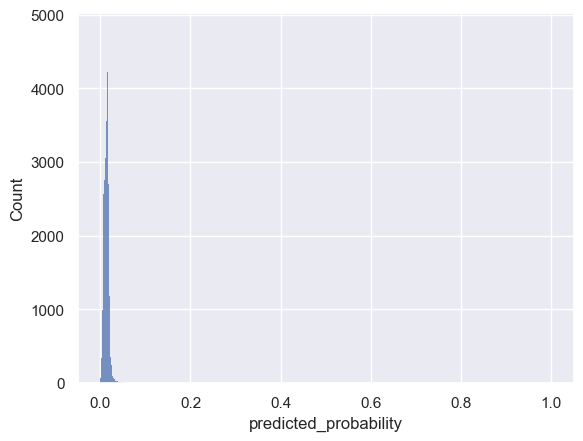

In [68]:
sns.histplot(predictions['predicted_probability'])

ROC AUC 0.828515403276065


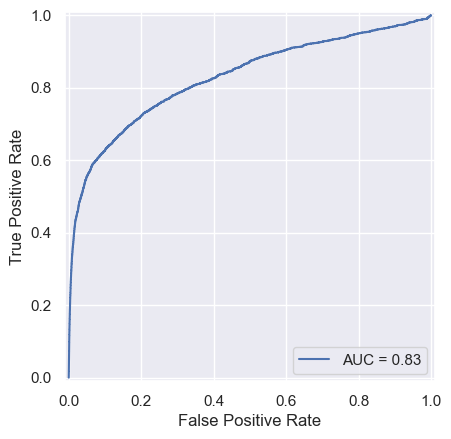

In [69]:
fpr, tpr, thresholds = metrics.roc_curve(predictions['default'], predictions['predicted_probability'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

## Walk forward

In [70]:
def predictor(new_df, model):
    predictions = model.predict(new_df)
    return(predictions)

In [71]:
def preprocessor(df, preproc_params = {}, new = True):
    
    
    return(df, preproc_params)

In [72]:
def estimator(df, fitting_algo, est_params = {}):
    
    my_formula = est_params['formula']
    model = fitting_algo(my_formula, data = df) 
    fitted_model = model.fit(disp=False)
    
    return(fitted_model)

In [73]:
def progress_bar(k, n, incr_txt="Step", bar_len = 10):
   
    bar_char  = u'\u25A5'
    line_char = u'\u21E2' # u'\u2192'  u'\u23AF' u'\u25AD'
    
    places   = int(np.ceil(n/bar_len))
    pct      = k/n
    n_str    = "{:,.0f}".format(n)        
    k_str    = "{:,.0f}".format(k)
    pct_str  = "{:,.0f}%".format(k/n * 100)
    # d_format = "%" + str(places) + "d"
    
    if k == n-1:
        n_bars = bar_len
        n_spaces = 0
        text_txt = "Completed " + n_str + " " + incr_txt + "s."
    else:
        n_bars   = int(np.floor(pct * bar_len))
        n_spaces = bar_len - n_bars
        text_txt = " " + pct_str +  " (" + incr_txt + " " + k_str + " of  " + n_str + ")."

    bar_txt  = "[" + "".ljust(n_bars,bar_char) + "".rjust(n_spaces,line_char) + "]  " 

    clear_output()
    display(bar_txt + text_txt)

In [148]:
def walk_forward_harness(df, preprocessor, estimator, predictor, 
                         start, date_col = 'Date', step_size = 1):     
    predictions = []
    model_list = []
    group_list = []
    
    stats_list = []
    def_percent = []
    
    # preproc_params = {
    #     'scaler':StandardScaler()
    # }
    proc_all_data , _= preprocessor(df, {})

    labels = []

    algo_params = {
        'formula': 'default ~ '+' + '.join(feature_list)
    }
    
    df[date_col] = pd.to_datetime(df[date_col])
    walk_range = df[date_col].dt.year.unique()
    
    for i in range(start,len(walk_range), step_size):
        
        train_idx = walk_range[:i]
        test_idx = [walk_range[i]]

        # print('train',train_idx)
        # print('test',test_idx)
        
        train_data = proc_all_data[proc_all_data[date_col].dt.year.isin(train_idx)]
        test_data = proc_all_data[proc_all_data[date_col].dt.year.isin(test_idx)]

        algo = smf.logit
    
        trained_model = estimator(train_data, algo, algo_params)
        prediction = predictor(test_data, trained_model)
        
        
        labels += list(test_data['default'].values)
        predictions += list(prediction.values)
        
        group_list += test_idx * len(prediction.values)
        
        try:
            score = metrics.roc_auc_score(y_score=predictions, y_true=labels)
            
        except Exception as e:
            print(F'Error scoring {e}')
            score = np.nan

        
        stats_list.append(score)
        model_list.append(trained_model)
        

        progress_bar(i, len(walk_range))
    
    predictions = pd.DataFrame([labels,predictions,group_list]).T
    predictions.columns = ['label','prediction','group']
    #predictions.set_index('index', inplace=True)
    
    return(predictions, model_list, stats_list)

In [158]:
predictions, model_list, stats_list = walk_forward_harness(modeling_df,
                                                           preprocessor = preprocessor, 
                                                           estimator = estimator, 
                                                           predictor = predictor, 
                                                           date_col = 'stmt_date',
                                                           start = 1, 
                                                           step_size = 1)

'[▥▥▥▥▥▥▥▥▥▥]  Completed 6 Steps.'

ROC AUC 0.7939441207966718


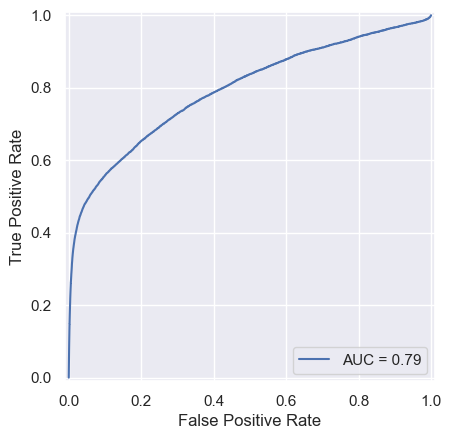

In [159]:
fpr, tpr, thresholds = metrics.roc_curve(predictions['label'], predictions['prediction'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

array([2008., 2009., 2010., 2011., 2012.])

Text(0, 0.5, 'ROC AUC score (for that test set of size Step)')

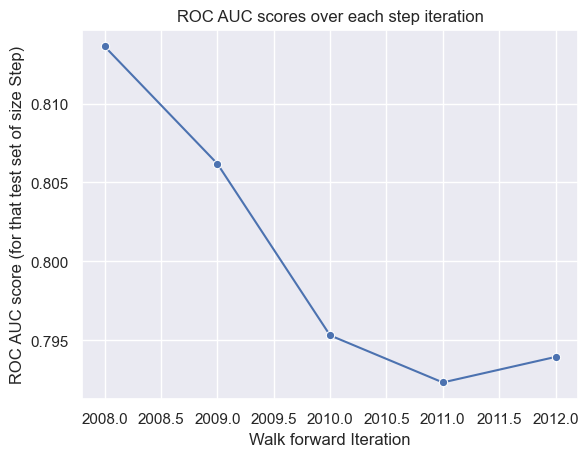

In [163]:
sns.lineplot(x=predictions['group'].unique(), y=stats_list, marker="o")
plt.title('ROC AUC scores over each step iteration')
plt.xlabel('Walk forward Iteration')
plt.ylabel('ROC AUC score (for that test set of size Step)')

In [164]:
default_data_viz = predictions.groupby('group')['label'].mean()

Text(0, 0.5, '% of defaults')

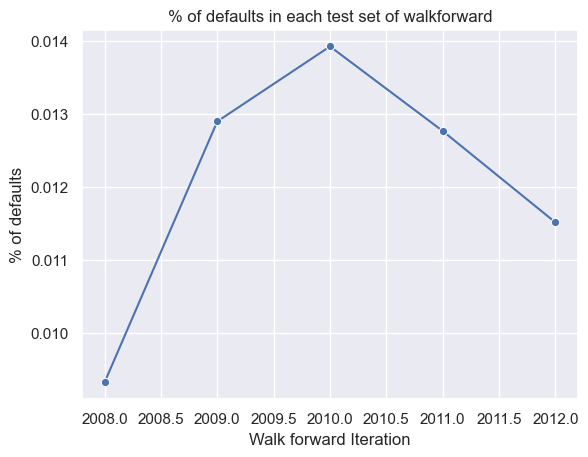

In [165]:
sns.lineplot(x=default_data_viz.index, y=default_data_viz, marker="o")
plt.title('% of defaults in each test set of walkforward')
plt.xlabel('Walk forward Iteration')
plt.ylabel('% of defaults')